<a href="https://colab.research.google.com/github/mohammadsanaee/ML_in_application/blob/main/6_rnn_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title <b><font color="red">▶</font><font color="black"> run this cell to prepare supplementary materials for the lesson</font></b>

!rm -rf harbour-space-text-mining-course
!git clone https://github.com/horoshenkih/harbour-space-text-mining-course.git
import sys
if 'harbour-space-text-mining-course' not in sys.path:
    sys.path.append('harbour-space-text-mining-course')

# from tmcourse.demo import (
# )
# from tmcourse.quiz import (
# )
from tmcourse.ipyquiz import Quiz, Function
from tmcourse.utils import enable_mathjax_in_cell

from IPython.display import HTML, display

# get_ipython().events.register('pre_run_cell', enable_mathjax_in_cell)
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 6.0)

import torch
torch.manual_seed(0)


Cloning into 'harbour-space-text-mining-course'...
remote: Enumerating objects: 734, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 734 (delta 77), reused 157 (delta 69), pack-reused 563
Receiving objects: 100% (734/734), 179.49 MiB | 24.38 MiB/s, done.
Resolving deltas: 100% (401/401), done.
Checking out files: 100% (129/129), done.


<!--@slideshow slide-->
<h1><center>Recurrent Neural Networks - 2</center></h1>


<!--@slideshow slide-->
# Last time
1. Recurrent functions accept sequences as inputs.
$$
h_t = f(x_t, h_{t-1})
$$
1. Recurrent Neural Networks are recurrent _layers_: they consist of linear transformations followed by activation functions.
$$
h_t = \mathrm{SomeFunction}(W_{xh}x_t + W_{hh}h_{t-1})
$$
1. RNNs are trained with backpropagation on "unrolled" computational graph.
1. Example: classification of names with RNN.

<!--@slideshow slide-->
# Plan for today
1. Methods of gradient optimization.
1. When RNN fails: conflicting updates.
1. Long Short-Term Memory (LSTM)

<!--@slideshow slide-->
# Methods of gradient optimization
## Colab demo: gradient methods for neural networks
[link](https://colab.research.google.com/drive/1TEX4GuQLU1oEYes-zhAMvoahRZ1yJHMl?usp=sharing)

<!--@slideshow slide-->
## Colab demo: PyTorch optimizers

In [ ]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    # the same as LanguageModelRNN from the previous lecture, but without conditioning
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size

        # hidden -> hidden
        self.hh = nn.Linear(hidden_size, hidden_size)
        # input -> hidden
        self.xh = nn.Linear(input_size, hidden_size)
        # hidden -> output
        self.hy = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, h):
        # h_t = f(h_{t-1}, x_t)
        hidden = self.relu(self.hh(h) + self.xh(x))
        # o_t = g(h_t)
        output = self.softmax(self.hy(hidden))
        return output, hidden

    def h0(self):
        return torch.zeros(1, self.hidden_size)

`process_sequence_rnn()` builds many-to-many computational graph.

![link text](https://raw.githubusercontent.com/horoshenkih/harbour-space-text-mining-course/master/pic/rnn-lm.png)

In [ ]:
def process_sequence_rnn(
    rnn,
    input_line_tensor,
    target_line_tensor,
    learning_rate
):
    # instead of manual parameter update, we will use PyTorch optimizer
    # create the optimizer
    optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
    optimizer.zero_grad()

    loss_function = nn.NLLLoss()
    hidden = rnn.h0()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(input_line_tensor[i], hidden)
        # update the loss for each element x_t
        l = loss_function(output, target_line_tensor[i])
        loss += l

    loss.backward()

    # perform gradient step
    
    # last time, we implemented the gradient step like this:
    # >> with torch.no_grad():
    # >>     for parameter in rnn.parameters():
    # >>         parameter -= learning_rate * parameter.grad

    # now, we use optimizer
    optimizer.step()

    return loss.item() / input_line_tensor.size(0)

<!--@slideshow slide-->
# When RNN fails: conflicting updates

In [ ]:
#@slideshow slide
def toy_example(char_seq):
    """
    Synthetic dataset.
    Input: sequence of characters `char_seq`.
    Target: "turn on" 1 if "+" is found, wait for "-" to "turn off".
    """
    target = []
    turned_on = 0
    for c in char_seq:
        if c == "+":
            turned_on = 1
        elif c == "-":
            turned_on = 0
        target.append(turned_on)
    return target

inp = "aajh-dd+dklddf+dd-jjola"
print("input: ", inp)
print("target:", "".join(map(str, toy_example(inp))))

input:  aajh-dd+dklddf+dd-jjola
target: 00000001111111111000000


<!--@slideshow slide-->
## Colab demo: train RNN on the toy dataset

Generate synthetic sequences with `generate_data()`.

In [ ]:
import torch
import random

def get_vocabulary(n_additional_symbols):
    lower = "abcdefghijklmnopqrstuvwxyz"
    return list("+-" + lower[:n_additional_symbols])

def generate_data(n_samples, seed=0, n_additional_symbols=0):
    alphabet = get_vocabulary(n_additional_symbols)
    random.seed(seed)

    char_tensor = torch.zeros(n_samples, 1, len(alphabet))  # one-hotted, 1 batch
    target_tensor = torch.zeros(n_samples, 1)
    index_seq = random.choices(range(len(alphabet)), k=n_samples)
    char_seq = [alphabet[i] for i in index_seq]  # human-readable
    for k, idx in enumerate(index_seq):
        char_tensor[k][0][idx] = 1
    
    # target: turn on if "+", turn off if "-"
    target_seq = toy_example(char_seq)
    for i, target in enumerate(target_seq):
        target_tensor[i][0] = target

    return "".join(char_seq), "".join(map(str, target_seq)), char_tensor, target_tensor.type(torch.LongTensor)

print("0 additional symbols")
chars, target, chars_tensor, target_tensor = generate_data(100)
print(chars)
print(target)
print()

print("10 additional symbols")
chars, target, chars_tensor, target_tensor = generate_data(100, n_additional_symbols=10)
print(chars)
print(target)

0 additional symbols
--++-+-++---+--+----+---+++---+-+--+-+--++-++-+-+--+++--+--------+-+-+++--++-------+-+------+----+-+
0011010110001001000010001110001010010100110110101001110010000000010101110011000000010100000010000101

10 additional symbols
ihdbechbdfiebhfbijhibgigd-dfijdibhe+gchg+diabiaeajhd+bej-egehejffdfcebaaffd-hijiijecgbhiifjedfjjh+fd
0000000000000000000000000000000000011111111111111111111100000000000000000000000000000000000000000111


Training loop for many-to-many RNN.

In [ ]:
def train_many_to_many_rnn(
    n_additional_symbols=0,
    hidden_size=16,
    sequence_length=50,
    n_iters=1000,
    learning_rate=0.0005
):
    from tqdm.notebook import tqdm
    import numpy as np
    import matplotlib.pyplot as plt
    print_every = n_iters // 20

    rnn = RNN(n_additional_symbols + 2, hidden_size, 2)
    all_losses = []
    iterations = []
    losses = []

    for i in tqdm(range(1, n_iters + 1)):
        # random sample
        chars, target, input_tensor, target_tensor = generate_data(
            sequence_length,
            seed=i,
            n_additional_symbols=n_additional_symbols
        )
        loss = process_sequence_rnn(
            rnn,
            input_tensor,
            target_tensor,
            learning_rate
        )

        all_losses.append(loss)

        if i % print_every == 0:
            iterations.append(i)
            avg_loss = np.mean(all_losses[-print_every:])
            losses.append(avg_loss)
            print(f"iteration {i}: loss {avg_loss}")

    plt.plot(iterations, losses)
    plt.show()

    return rnn

Auxiliary functions.

In [ ]:
def evaluate(rnn, input_tensor):
    # read the sequence and return the final output
    hidden = rnn.h0()

    outputs = torch.zeros(input_tensor.size()[0], 1, 2)
    for i in range(input_tensor.size()[0]):
        output, hidden = rnn(input_tensor[i], hidden)
        outputs[i][0] = output

    return outputs

def prediction_chars(prediction_tensor):
    chars = []
    for i in range(prediction_tensor.size()[0]):
        if prediction_tensor[i][0][0] > prediction_tensor[i][0][1]:
            chars.append('0')
        else:
            chars.append('1')
    return chars

def visualize_predictions(rnn, seed, n_additional_symbols, sequence_length=50):
    chars, target, input_tensor, target_tensor = generate_data(
        sequence_length,
        seed=seed,
        n_additional_symbols=n_additional_symbols
    )

    prediction = evaluate(rnn, input_tensor)

    print("input:     ", "".join(chars))
    print("target:    ", "".join(target))
    print("prediction:", "".join(prediction_chars(prediction)))

### Case 1: 2 symbols in the input sequence (no additional symbols)

This is an easy task for RNN, training converges quickly, the resulting loss is close to 0.

  0%|          | 0/1500 [00:00<?, ?it/s]

iteration 75: loss 0.5581459976196288
iteration 150: loss 0.4148217315673828
iteration 225: loss 0.29125918045043947
iteration 300: loss 0.19420498593648278
iteration 375: loss 0.12064695307413736
iteration 450: loss 0.0699927365620931
iteration 525: loss 0.037728096675872805
iteration 600: loss 0.018823943010965984
iteration 675: loss 0.008651627421379088
iteration 750: loss 0.00393922123114268
iteration 825: loss 0.0016431891312201816
iteration 900: loss 0.0006578736911217371
iteration 975: loss 0.00024222832098603244
iteration 1050: loss 8.908746720602114e-05
iteration 1125: loss 3.033862377827366e-05
iteration 1200: loss 1.0989124223124237e-05
iteration 1275: loss 3.7800794331512096e-06
iteration 1350: loss 1.1880382992482436e-06
iteration 1425: loss 4.5791869500438524e-07
iteration 1500: loss 1.4953548082606477e-07


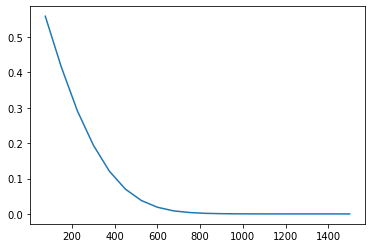

In [ ]:
rnn = train_many_to_many_rnn(n_additional_symbols=0, n_iters=1500)

In [ ]:
visualize_predictions(rnn, 99999, 0)

input:      ++--+++---+++----+-+--+-+-----+-+--+-++++-+----+++
target:     11001110001110000101001010000010100101111010000111
prediction: 11001110001110000101001010000010100101111010000111


### Case 2: 10 additional symbols
More iterations are needed to converge, the resulting loss is higher.

  0%|          | 0/4000 [00:00<?, ?it/s]

iteration 200: loss 0.691795627784729
iteration 400: loss 0.6508998291015626
iteration 600: loss 0.6141790405273437
iteration 800: loss 0.5157744303703308
iteration 1000: loss 0.45412872333526605
iteration 1200: loss 0.3877144681453704
iteration 1400: loss 0.3327460609912872
iteration 1600: loss 0.281032957649231
iteration 1800: loss 0.23419987220764163
iteration 2000: loss 0.1960661535143852
iteration 2200: loss 0.14156381868720053
iteration 2400: loss 0.11410199961662293
iteration 2600: loss 0.12224944688379764
iteration 2800: loss 0.08834932101219893
iteration 3000: loss 0.08600135546326637
iteration 3200: loss 0.09982238504588604
iteration 3400: loss 0.09064039874076844
iteration 3600: loss 0.07456546059660614
iteration 3800: loss 0.05995532962083818
iteration 4000: loss 0.08615224209968002


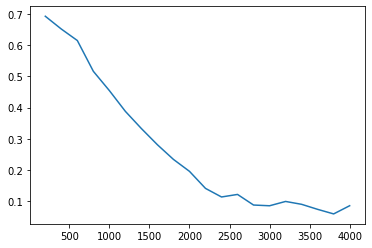

In [ ]:
rnn = train_many_to_many_rnn(n_additional_symbols=10, n_iters=4000)

In [ ]:
visualize_predictions(rnn, 99999, 10)

input:      -bjgcacjfh+bcehegajbhg-f-fiefjchcge-ic++dh+iehfb+c
target:     00000000001111111111110000000000000000111111111111
prediction: 00000000001111111111110000000000000000111111111111


### Case 3: 26 additional symbols
Note that there are 28 symbols but only 16 components in the hidden state.
This is typical for practical applications: the size of vocabulary is larger than the number of components of the hidden state.

The loss is high during training, more iterations don't help.

  0%|          | 0/15000 [00:00<?, ?it/s]

iteration 750: loss 0.6606282354227702
iteration 1500: loss 0.5862316585413615
iteration 2250: loss 0.6124177056233089
iteration 3000: loss 2.12382915850242
iteration 3750: loss 38.05549560994506
iteration 4500: loss 456.64324067948303
iteration 5250: loss 553.1252445505901
iteration 6000: loss 4257.646193877628
iteration 6750: loss 2435.388580753852
iteration 7500: loss 6.542113442253605
iteration 8250: loss 313.0034768409245
iteration 9000: loss 528.204141010056
iteration 9750: loss 204.07973027119988
iteration 10500: loss 2210.2421438552856
iteration 11250: loss 8181.382853745813
iteration 12000: loss 25681.557764648158
iteration 12750: loss 832.8795456299772
iteration 13500: loss 643.3156839708037
iteration 14250: loss 178.94751555121283
iteration 15000: loss 2931.495357859766


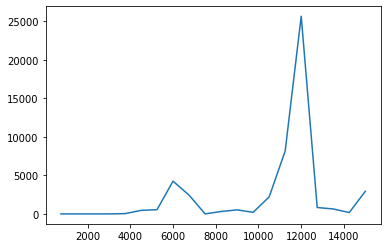

In [ ]:
rnn = train_many_to_many_rnn(n_additional_symbols=26, n_iters=15000)

In [ ]:
visualize_predictions(rnn, 99999, 26)

input:      bgyshdjxov-hioumrczhusaqboxmqzjuismbvj++jt-xnuqg+h
target:     00000000000000000000000000000000000000111100000011
prediction: 00000000000000000000000000000000000000000000000000


<!--@slideshow slide-->
## Problem: conflicting updates

RNN update rule:
$$
h_t = f(W_{xh} x_t + W_{hh} h_{t-1})
$$

**Problem**: $h_t$ is always updated, but _sometimes_ (for some inputs) we want to protect it from updates.


<!--@slideshow slide-->

**Notation**: one-hot encoding of inputs and outputs.

**Input**:
$x = (0, 1, \dots)^T$
corresponds to `"+"` character, and
$x = (1, 0, \dots)^T$
corresponds to `"-"` character.

Any other character is represented as
$x = (0, 0, \dots)^T$

**Output**:
$h = (0, 1)^T$
corresponds to label 1, and
$h = (1, 0)^T$
corresponds to label 0.

<!--@slideshow fragment-->
Only the first two components of $x_t$ are relevant, so we want
$$
W_{xh} = \begin{pmatrix}
1 & 0 & 0 & 0 & \dots\\
0 & 1 & 0 & 0 & \dots\\
\end{pmatrix}
$$

We need the update rule with "protection":
$$
h_t = \begin{cases}
W_{xh} x_t & \textrm{if }W_{xh} x_t \textrm{ is nonzero}\\
h_{t-1}, & \textrm{if }W_{xh} x_t \textrm{ is zero}
\end{cases}
$$

<!--@slideshow slide-->
# Long Short-Term Memory (LSTM)

[Sepp Hochreiter and Jürgen Schmidhuber, “Long Short-Term Memory,” Neural Computation 9, no. 8 (1997).](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.676.4320&rep=rep1&type=pdf)

<table>
  <tr>
    <td><img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/05/Example-of-LSTM-Architecture.png" height="400"/></td>
    <td><img src="https://static.tvtropes.org/pmwiki/pub/images/6db_3.jpg" height="400"/> </td> 
  </tr>
</table>


<!--@slideshow slide-->
**Idea**: treat the hidden state as "memory" and control its updates depending on the input.

> This is the same what we do in the toy example: update the state only for the particular inputs (`"+"` or `"-"`).

<!--@slideshow fragment-->
**What we have**: layers (matrices + nonlinearities).

**What we want**: memory, conditions (if-else).

<!--@slideshow slide-->
**Memory** will be represented as a vector.
- Each element stores a real number.
- An element can be erased.
- An element can be incremented/decremented.

<!--@slideshow fragment-->
**Conditions** correspond to the _sigmoid function_, which returns values between 0 ("False") and 1 ("True").

<!--@slideshow fragment-->
**Memory updates** (increments and decrements) correspond to _tanh_, which returns values between -1 ("decrement") and 1 ("increment").

<!--@slideshow slide-->
## 1. Cell state and output gate

In general, algorithms don't return the full memory state. So we need to
1. Separate the full memory state from the returning state
1. Decide which parts of the full memory state to return


<!--@slideshow fragment-->
The full memory state is called **cell state** $c_t$.

From the cell state $c_t$, we "return" only some elements.


<!--@slideshow slide-->
We need a function $o_t$ that tells which elements of $c_t$ should be returned:
- This function depends on inputs: $o_t(x_t, h_{t-1})$.
- For each element, it should "return" 0 or 1.
- We will _learn_ this function, so represent it as a layer:
$$
o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho})
$$

The function $o_t$ that decides which parts of memory to return is called **output gate**.


<!--@slideshow fragment-->
Also, we control the magnitute of the output using tanh:
$$
h_t = o_t \odot \mathrm{tanh}(c_t)
$$

<!--@slideshow slide-->
## 2. Update cell state

From the input $x_t, h_{t-1}$, we decide how to update the cell state $c_t$ (increment or decrement elements).
$$
g_t = \mathrm{tanh}(W_{ig}x_t + b_{ig} + W_{hg}h_{t-1} + b_{hg})
$$




<!--@slideshow fragment-->
But we cannot write
$$
c_t = g_t
$$
because we also need to _protect_ some parts of memory.

<!--@slideshow slide-->
## 3. Input gate and forget gate

To _protect_ some parts of memory $c_t$ from overwriting, we need a function $i_t$ that tells which elements should be overwritten.


<!--@slideshow fragment-->
Again, it should return "boolean" (between 0 and 1) values, and we learn it, so it is a layer:
$$
i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi}h_{t-1} + b_{hi})
$$

This function is called **input gate**.

<!--@slideshow slide-->
Similarly, we need to erase (forget) some parts of memory.




<!--@slideshow fragment-->
We need a function $f_t$  (**forget gate**) that "zeroes out" some elements of $c_t$ depending on input.
$$
f_t = \sigma(W_{if}x_t + b_{if} + W_{hf} h_{t-1} + b_{hf})
$$

<!--@slideshow slide-->
The final update of the cell state is
$$
c_t = f_t \odot c_{t-1} + i_t \odot g_t
$$

<!--@slideshow slide-->
Putting it all together, we obtain _LSTM equations_:

$$
i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi}h_{t-1} + b_{hi})
$$
$$
f_t = \sigma(W_{if}x_t + b_{if} + W_{hf} h_{t-1} + b_{hf})
$$
$$
g_t = \mathrm{tanh}(W_{ig}x_t + b_{ig} + W_{hg}h_{t-1} + b_{hg})
$$
$$
o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho})
$$
$$
c_t = f_t \odot c_{t-1} + i_t \odot g_t
$$
$$
h_t = o_t \odot \mathrm{tanh}(c_t)
$$

<!--@slideshow slide-->
## Colab demo: LSTM implementation in PyTorch

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size

        # input gate
        self.ii = nn.Linear(input_size, hidden_size)
        self.hi = nn.Linear(hidden_size, hidden_size)

        # forget gate
        self.if_ = nn.Linear(input_size, hidden_size)
        self.hf = nn.Linear(hidden_size, hidden_size)

        # cell
        self.ig = nn.Linear(input_size, hidden_size)
        self.hg = nn.Linear(hidden_size, hidden_size)

        # output gate
        self.io = nn.Linear(input_size, hidden_size)
        self.ho = nn.Linear(hidden_size, hidden_size)

        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

        # transformation of LSTM output to log-probabilities
        self.oo = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, state):
        h, c = state  # state is a pair of hidden state and cell state

        # input gate
        i = self.sigmoid(self.ii(x) + self.hi(h))
        # forget gate
        f = self.sigmoid(self.if_(x) + self.hf(h))
        # cell
        g = self.tanh(self.ig(x) + self.hg(h))
        # output gate
        o = self.sigmoid(self.io(x) + self.ho(h))

        # update cell state
        cell = f * c + i * g
        # update hidden state
        hidden = o * self.tanh(cell)

        # output
        output = self.softmax(self.oo(hidden))

        return output, (hidden, cell)

    def h0c0(self):
        return torch.zeros(1, self.hidden_size), torch.zeros(1, self.hidden_size)

In [ ]:
def process_sequence_lstm(
    lstm,
    input_line_tensor,
    target_line_tensor,
    learning_rate
):
    loss_function = nn.NLLLoss()
    state = lstm.h0c0()
    lstm.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, state = lstm(input_line_tensor[i], state)
        # update the loss for each element x_t
        l = loss_function(output, target_line_tensor[i])
        loss += l

    loss.backward()

    # instead of manual parameter update, we use PyTorch optimizer
    # create the optimizer
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
    # perform gradient step
    optimizer.step()

    return loss.item() / input_line_tensor.size(0)

In [ ]:
def train_many_to_many_lstm(
    n_additional_symbols=0,
    hidden_size=16,
    sequence_length=50,
    n_iters=1000,
    learning_rate=0.0005
):
    from tqdm.notebook import tqdm
    import numpy as np
    import matplotlib.pyplot as plt
    print_every = n_iters // 20

    lstm = LSTM(n_additional_symbols + 2, hidden_size, 2)
    all_losses = []
    iterations = []
    losses = []

    for i in tqdm(range(1, n_iters + 1)):
        # random sample
        chars, target, input_tensor, target_tensor = generate_data(
            sequence_length,
            seed=i,
            n_additional_symbols=n_additional_symbols
        )
        loss = process_sequence_lstm(
            lstm,
            input_tensor,
            target_tensor,
            learning_rate
        )

        all_losses.append(loss)

        if i % print_every == 0:
            iterations.append(i)
            avg_loss = np.mean(all_losses[-print_every:])
            losses.append(avg_loss)
            print(f"iteration {i}: loss {avg_loss}")

    plt.plot(iterations, losses)
    plt.show()

    return lstm

### Case 1: 2 symbols in the input sequence (no additional symbols)

Sanity check: LSTM converges quickly.

  0%|          | 0/1500 [00:00<?, ?it/s]

iteration 75: loss 0.6853904368082683
iteration 150: loss 0.6255009628295899
iteration 225: loss 0.5540985844930013
iteration 300: loss 0.46884996185302746
iteration 375: loss 0.3789133214314778
iteration 450: loss 0.29582710418701175
iteration 525: loss 0.22046806106567382
iteration 600: loss 0.15798457107543948
iteration 675: loss 0.10903880945841472
iteration 750: loss 0.0728042376836141
iteration 825: loss 0.04684780263900757
iteration 900: loss 0.029208191045125335
iteration 975: loss 0.01748997343381246
iteration 1050: loss 0.010076893798510234
iteration 1125: loss 0.00566928207874298
iteration 1200: loss 0.0031127456724643707
iteration 1275: loss 0.0016654585947593053
iteration 1350: loss 0.0008700144300858181
iteration 1425: loss 0.00044187029153108586
iteration 1500: loss 0.00021776561575631302


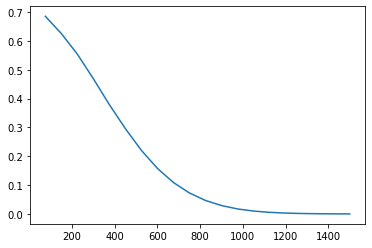

LSTM(
  (ii): Linear(in_features=2, out_features=16, bias=True)
  (hi): Linear(in_features=16, out_features=16, bias=True)
  (if_): Linear(in_features=2, out_features=16, bias=True)
  (hf): Linear(in_features=16, out_features=16, bias=True)
  (ig): Linear(in_features=2, out_features=16, bias=True)
  (hg): Linear(in_features=16, out_features=16, bias=True)
  (io): Linear(in_features=2, out_features=16, bias=True)
  (ho): Linear(in_features=16, out_features=16, bias=True)
  (tanh): Tanh()
  (sigmoid): Sigmoid()
  (oo): Linear(in_features=16, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
train_many_to_many_lstm(n_additional_symbols=0, n_iters=1500)

### Case 2: 10 additional symbols

LSTM has lower loss compared to RNN.

  0%|          | 0/4000 [00:00<?, ?it/s]

iteration 200: loss 0.6803459321975709
iteration 400: loss 0.6366172424316406
iteration 600: loss 0.5462216360092164
iteration 800: loss 0.47579896249771125
iteration 1000: loss 0.3958074868202209
iteration 1200: loss 0.33549606347084043
iteration 1400: loss 0.3019349523544312
iteration 1600: loss 0.25357865896224974
iteration 1800: loss 0.20622973811626433
iteration 2000: loss 0.15115934457778932
iteration 2200: loss 0.10873711191415786
iteration 2400: loss 0.06118206797242164
iteration 2600: loss 0.04465319163799286
iteration 2800: loss 0.023056439572572706
iteration 3000: loss 0.012743152847886085
iteration 3200: loss 0.014612113704252994
iteration 3400: loss 0.000605198128533084
iteration 3600: loss 0.00016577378510264677
iteration 3800: loss 3.6942582538176795e-05
iteration 4000: loss 8.052367149502971e-06


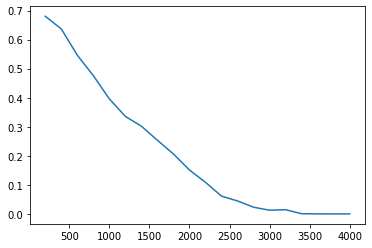

LSTM(
  (ii): Linear(in_features=12, out_features=16, bias=True)
  (hi): Linear(in_features=16, out_features=16, bias=True)
  (if_): Linear(in_features=12, out_features=16, bias=True)
  (hf): Linear(in_features=16, out_features=16, bias=True)
  (ig): Linear(in_features=12, out_features=16, bias=True)
  (hg): Linear(in_features=16, out_features=16, bias=True)
  (io): Linear(in_features=12, out_features=16, bias=True)
  (ho): Linear(in_features=16, out_features=16, bias=True)
  (tanh): Tanh()
  (sigmoid): Sigmoid()
  (oo): Linear(in_features=16, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
train_many_to_many_lstm(n_additional_symbols=10, n_iters=4000)

### Case 3: 26 additional symbols

Training converges, more iterations are better.

  0%|          | 0/15000 [00:00<?, ?it/s]

iteration 750: loss 0.6423196632130941
iteration 1500: loss 0.42056070839564
iteration 2250: loss 0.30242893667221066
iteration 3000: loss 0.23613269421418506
iteration 3750: loss 0.1200203790858388
iteration 4500: loss 0.0456985596239008
iteration 5250: loss 0.00981655317626217
iteration 6000: loss 0.001838315781279306
iteration 6750: loss 0.00042354356545370466
iteration 7500: loss 3.5820370664130983e-08
iteration 8250: loss 4.6449441731889836e-08
iteration 9000: loss 0.00195663765906842
iteration 9750: loss 4.16435677645192e-10
iteration 10500: loss 4.132587757036769e-11
iteration 11250: loss 5.086262471346952e-11
iteration 12000: loss 1.5894570424279662e-11
iteration 12750: loss 1.9073484812300496e-11
iteration 13500: loss 6.357828397085541e-12
iteration 14250: loss 6.357828397085541e-12
iteration 15000: loss 1.2715656415214957e-11


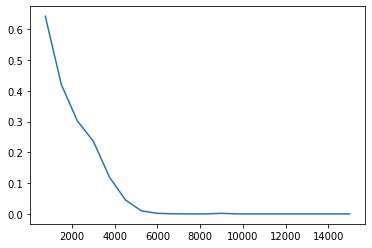

In [ ]:
lstm = train_many_to_many_lstm(n_additional_symbols=26, n_iters=15000)

<!--@slideshow slide-->
## Colab demo: `nn.LSTM`

In [ ]:
import torch
import torch.nn as nn

class ClassificationLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

        # keep hidden sise for initialization of h_0, c_0
        self.hidden_size = hidden_size

    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(1, 1, self.hidden_size)
        c0 = torch.zeros(1, 1, self.hidden_size)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (seq_len, batch, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.out(out[-1, :, :])

        return self.softmax(out)

In [ ]:
def process_sequence_classification_lstm(lstm, target_tensor, input_tensor, learning_rate):
    loss_function = nn.NLLLoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

    output = lstm(input_tensor)
    loss = loss_function(output, target_tensor)

    # backprop + update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

Get the data

In [ ]:
#@title run this cell to copy-paste the code from the previous lecture: get the data, define ClassificationRNN

from collections import defaultdict
category_to_names = defaultdict(list)
with open("harbour-space-text-mining-course/datasets/pytorch_tutorial/names_by_language.txt") as f:
    for line in f:
        name, category = line.strip().split("\t")
        category_to_names[category].append(name)

# count total number of letters
all_letters = set()
all_categories = set()

for category, names in category_to_names.items():
    all_categories.add(category)
    for name in names:
        all_letters.update(list(name))
all_letters = list(sorted(all_letters))
all_categories = list(sorted(all_categories))

def name_to_tensor(name, all_letters):
    tensor = torch.zeros(len(name), 1, len(all_letters))
    for li, letter in enumerate(name):
        letter_idx = all_letters.index(letter)
        tensor[li][0][letter_idx] = 1  # one-hot encoding
    return tensor

category_to_training_samples = defaultdict(list)
for category, names in category_to_names.items():
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    for name in names:
        name_tensor = name_to_tensor(name, all_letters)
        sample = category_tensor, name_tensor
        category_to_training_samples[category].append(sample)

class ClassificationRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # instead of explicit matrix multiplications, we use Linear layers
        # W_hh: hidden -> hidden
        self.hh = nn.Linear(hidden_size, hidden_size)
        # W_xh: input -> hidden
        self.xh = nn.Linear(input_size, hidden_size)
        # W_hy: hidden -> output
        self.hy = nn.Linear(hidden_size, output_size)

        # nonlinearities we will use:
        # ReLU for h_t = f(h_{t-1}, x_t)
        self.relu = nn.ReLU()
        # LogSoftmax for y_t = g(h_t) (because we are doing classification)
        self.softmax = nn.LogSoftmax(dim=1)

        # keep hidden sise for initialization of h_0
        self.hidden_size = hidden_size

    def forward(self, x, h):
        # h_t = f(h_{t-1}, x_t)
        hidden = self.relu(self.hh(h) + self.xh(x))
        # y_t = g(h_t)
        output = self.softmax(self.hy(hidden))
        return output, hidden

    def h0(self):
        # compute the initial value (all zeros) for the hidden state
        return torch.zeros(1, self.hidden_size)
import torch

def process_sequence_classification(rnn, target_tensor, input_tensor, learning_rate):
    """
    The algorithm:
    - Read the input sequence left-to-right
    - At each step, compute new hidden state and new output
    - Get the last output (probability distribution over classes) and compute loss
    - Backpropagate gradients and update parameters

    input_tensor is a 3-dimensional tensor: sequence length x 1 x vocabulary size
     - the first dimension: each element in this dimension corresponds to x_t
     - the second dimension is a "batch dimension", in our case it always contains 1 element
     - the last dimension contains components of x_t
    """

    # prepare for backprop
    rnn.zero_grad()
    # initialize hidden state
    hidden = rnn.h0()

    # read all elements of the input sequence, update hidden state and output
    for i in range(input_tensor.size()[0]):
        output, hidden = rnn(input_tensor[i], hidden)

    # get the last output, compute the loss function and backpropagate
    loss_function = nn.NLLLoss()
    loss = loss_function(output, target_tensor)
    loss.backward()

    # update parameters
    with torch.no_grad():
        for parameter in rnn.parameters():
            parameter -= learning_rate * parameter.grad

    return loss.item()

Create and train `ClassificationLSTM`. Compare with `ClassificationRNN`.

  0%|          | 0/30000 [00:00<?, ?it/s]

iteration 1500: LSTM loss 2.8803129607041678, RNN loss 2.8922096966107684
iteration 3000: LSTM loss 2.754323328177134, RNN loss 2.882747580051422
iteration 4500: LSTM loss 2.6458211202224096, RNN loss 2.8737022215525307
iteration 6000: LSTM loss 2.702673468788465, RNN loss 2.8660151451428733
iteration 7500: LSTM loss 2.6169950920939447, RNN loss 2.854747447490692
iteration 9000: LSTM loss 2.587603723833958, RNN loss 2.8439748916625978
iteration 10500: LSTM loss 2.5558325101137163, RNN loss 2.8373699741363527
iteration 12000: LSTM loss 2.578670886327823, RNN loss 2.828503492037455
iteration 13500: LSTM loss 2.4939204195862015, RNN loss 2.8112658767700194
iteration 15000: LSTM loss 2.4599703561874726, RNN loss 2.7997008919715882
iteration 16500: LSTM loss 2.4154910963264604, RNN loss 2.7816403090159096
iteration 18000: LSTM loss 2.3905178098392983, RNN loss 2.7635065960884093
iteration 19500: LSTM loss 2.377405059256901, RNN loss 2.750637503862381
iteration 21000: LSTM loss 2.22939751607

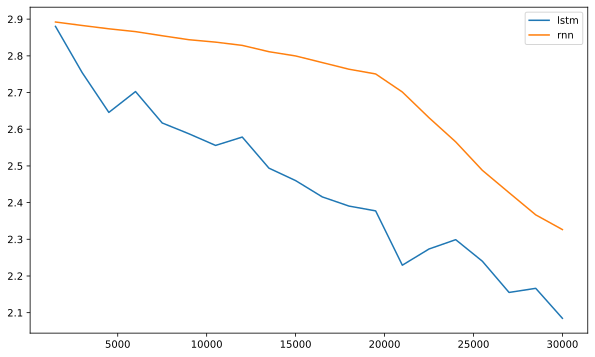

In [ ]:
n_hidden = 128
classification_lstm = ClassificationLSTM(len(all_letters), n_hidden, len(all_categories))
classification_rnn = ClassificationRNN(len(all_letters), n_hidden, len(all_categories))

import math
from tqdm.notebook import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
random.seed(0)

n_iters = 30000
print_every = 1500

all_losses = []
iterations = []
losses = []
all_rnn_losses = []
rnn_losses = []

for i in tqdm(range(1, n_iters + 1)):
    random_category = random.choice(all_categories)
    category_tensor, name_tensor = random.choice(category_to_training_samples[random_category])

    loss = process_sequence_classification_lstm(classification_lstm, category_tensor, name_tensor, 0.0005)
    all_losses.append(loss)

    rnn_loss = process_sequence_classification(classification_rnn, category_tensor, name_tensor, 0.001)
    all_rnn_losses.append(rnn_loss)
    if i % print_every == 0:
        iterations.append(i)
        avg_loss = np.mean(all_losses[-print_every:])
        losses.append(avg_loss)
        avg_rnn_loss = np.mean(all_rnn_losses[-print_every:])
        rnn_losses.append(avg_rnn_loss)
        print(f"iteration {i}: LSTM loss {avg_loss}, RNN loss {avg_rnn_loss}")

plt.plot(iterations, losses, label="lstm")
plt.plot(iterations, rnn_losses, label="rnn")
plt.legend()
plt.show()

<!--@slideshow slide-->
# Summary
1. Methods of gradient optimization: "vanilla", momentum, Nesterov momentum, Adagrad, RMSProp, Adam.
1. Conflicting updates in RNN
1. Long Short-Term Memory (LSTM)
  - Treat the hidden state as "memory" and control its updates depending on the input.
  - Cell state and cell update
  - Output gate
  - Input gate
  - Forget gate

<!--@slideshow slide-->
# Recommended resources
- [Deep Learning Book, ch. 10: Sequence Modeling: Recurrentand Recursive Nets](https://www.deeplearningbook.org/contents/rnn.html)
- [Understanding LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [Sepp Hochreiter and Jürgen Schmidhuber, “Long Short-Term Memory,” Neural Computation 9, no. 8 (1997).](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.676.4320&rep=rep1&type=pdf)

<!--@slideshow slide-->
# Home assignment 6
## Exercise 1 (2 points)
Refactor your solution from the Home Assignment 4: in the function `train_clf`, use Adam optimizer.

## Exercise 2 (4 points)
Refactor your solution from the Home Assignment 5 (Exercise 2): use `nn.LSTM` in `ClassificationRNN`.